In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("..")
import model_parts

In [2]:
twitter_df = pd.read_csv("../data/trump_twitter_200905_201607.csv")
twitter_df = model_parts.preprocessing(twitter_df)
twitter_df["text"] = twitter_df["text"].str.replace("\s+", ' ', regex=True)
X_train, X_test, y_train, y_test = model_parts.create_train_test(twitter_df)

Removed 90 rows during preprocessing
Combining 35 multipart messages
Train
not_trump:trump 11000:8402
Test
not_trump:trump 2693:3775


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion

clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english',
                              ngram_range=(1, 2))),
    ('classifier', LogisticRegression(solver='lbfgs',
                                      max_iter=1000))
])

clf.fit(X_train.text, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

Evaluating with threshold: 0.5
AUC: 0.746
TN: 2224 FP: 469
FN: 1710 TP: 2065


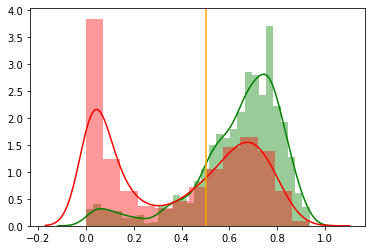

In [5]:
model_parts.evaluate_model(X_test.text, y_test, clf)

## Understanding False Positives

So our model seems to be quite okay at find the real trump's messages. Unfortunately there are still a lot of false postives, which we'll try and understand better here.

For now we'll focus on false positives with a threshold of `0.5`

In [6]:
y_probs = clf.predict_proba(X_test.text)[:,1]
fp_ind = (y_probs > 0.5) & ~y_test

for msg in X_test[fp_ind]["text"][:10].values:
    print(msg)

@KyndalBass Thank you Jill Marlon & all @TrumpChicago for the amazing & personal service. #Chicago'sBestHotel #Trump2016 Thanks.
@therealtommydel Trump for President! Tom Brady as running mate?
@enzotorin @realDonaldTrump Trump is the man #Trump2016
@WilyKayote @LenToddWOR I hope the Don throws his hat in the ring for POTUS. He can't be bought! He said this country is going to Hell
@KhathuEnos ignoring haters and losers is the best medicine of success build a wall from whatever they throw towards you Sir.
@somegirl71 @realDonaldTrump Look forward to hearing you every Monday on @foxandfriends. You are exactly what this country needs!!!
@fackinpeter @realDonaldTrump im ready for u to make america great again
Via @HuffPostPol by @_under_current: “Donald Trump Will End Outsourcing If President” 
@iamgavinjame To make America great again we must #THINKBIG & understand that it's #TimeToGetTough on China! @realDonaldTrump will do that!,05-20-2015 16:44:25,21,41,false,601065955855376384 Twitte

Seems to be a data quality issue. These all look like retweets, while we had supposedly filtered those out. Lets look at the messages with `@realDonalTrump`, since it wouldn't really make much sense for trump to reference himself in his tweets.

In [12]:
from eli5.lime import TextExplainer

te = TextExplainer()
te.fit("@enzotorin @realDonaldTrump Trump is the man #Trump2016", clf.predict_proba)
te.explain_prediction()

Explanation(estimator="SGDClassifier(alpha=0.001, average=False, class_weight=None,\n       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,\n       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,\n       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='elasticnet',\n       power_t=0.5,\n       random_state=<mtrand.RandomState object at 0x7f391a892b40>,\n       shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,\n       warm_start=False)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='realdonaldtrump', weight=3.2244185364686646, std=None, value=1.0), FeatureWeight(feature='trump2016', weight=0.9791857220360473, std=None, value=1.0), FeatureWeight(feature='enzotorin realdonaldtrump', weight=0.8241177233384193, std=None, value=1.0), FeatureWeight(feature='man', weight=0.6802197933100591, std=None, value=1.0), FeatureWeight(feature='realdonaldtrump trump', weight=0.5794215351524116, std=None, value=1.0), FeatureWeight(feature='is the', weight=0.19365473495701088, std=None, value=1.0), FeatureWeight(feature='trump', weight=0.10524470978887482, std=None, value=1.0), FeatureWeight(feature='the man', weight=0.09830345428252237, std=None, value=1.0)], neg=[FeatureWeight(feature='man trump2016', weight=-0.7294508176281833, std=None, value=1.0), FeatureWeight(feature='is', weight=-0.14782010987698468, std=None, value=1.0), FeatureWeight(feature='enzotorin', weight=-0.10732211063400716, std=None, value=1.0), FeatureWeight(feature='the', weight=-0.08901952174745083, std=None, value=1.0), FeatureWeight(feature='<BIAS>', weight=-0.02561168093390968, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=0.9962615620375593, score=5.585341968513474, weighted_spans=WeightedSpans(docs_weighted_spans=[DocWeightedSpans(document='@enzotorin @realdonaldtrump trump is the man #trump2016', spans=[('enzotorin', [(1, 10)], -0.10732211063400716), ('realdonaldtrump', [(12, 27)], 3.2244185364686646), ('trump', [(28, 33)], 0.10524470978887482), ('is', [(34, 36)], -0.14782010987698468), ('the', [(37, 40)], -0.08901952174745083), ('man', [(41, 44)], 0.6802197933100591), ('trump2016', [(46, 55)], 0.9791857220360473), ('enzotorin realdonaldtrump', [(1, 10), (12, 27)], 0.8241177233384193), ('realdonaldtrump trump', [(12, 27), (28, 33)], 0.5794215351524116), ('is the', [(34, 36), (37, 40)], 0.19365473495701088), ('the man', [(37, 40), (41, 44)], 0.09830345428252237), ('man trump2016', [(41, 44), (46, 55)], -0.7294508176281833)], preserve_density=False, vec_name=None)], other=FeatureWeights(pos=[FeatureWeight(feature=<FormattedFeatureName 'Highlighted in text (sum)'>, weight=5.610953649447383, std=None, value=None)], neg=[FeatureWeight(feature='<BIAS>', weight=-0.02561168093390968, std=None, value=1.0)], pos_remaining=0, neg_remaining=0)))], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

In [10]:
te.fit("@WilyKayote @LenToddWOR I hope the Don throws his hat in the ring for POTUS. He can't be bought! He said this country is going to Hell", clf.predict_proba)
te.explain_prediction()

Explanation(estimator="SGDClassifier(alpha=0.001, average=False, class_weight=None,\n       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,\n       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,\n       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='elasticnet',\n       power_t=0.5,\n       random_state=<mtrand.RandomState object at 0x7f391a2272d0>,\n       shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,\n       warm_start=False)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='country', weight=0.3384696303057002, std=None, value=1.0), FeatureWeight(feature='hope', weight=0.23145967667307718, std=None, value=1.0), FeatureWeight(feature='hell', weight=0.22162673019564016, std=None, value=1.0), FeatureWeight(feature='the', weight=0.19463912435116235, std=None, value=2.0), FeatureWeight(feature='potus', weight=0.18321569082483366, std=None, value=1.0), FeatureWeight(feature='said', weight=0.16659458032178234, std=None, value=1.0), FeatureWeight(feature='going', weight=0.12336017093519676, std=None, value=1.0), FeatureWeight(feature='in', weight=0.10489760142212526, std=None, value=1.0), FeatureWeight(feature='for potus', weight=0.05133563170087838, std=None, value=1.0), FeatureWeight(feature='don throws', weight=0.04363523527004626, std=None, value=1.0), FeatureWeight(feature='lentoddwor i', weight=0.04043077244024096, std=None, value=1.0), FeatureWeight(feature='bought he', weight=0.025569849676983298, std=None, value=1.0), FeatureWeight(feature='t', weight=0.019858516619158075, std=None, value=1.0), FeatureWeight(feature='be bought', weight=0.015881045260562554, std=None, value=1.0), FeatureWeight(feature='can', weight=0.01105577234739837, std=None, value=1.0)], neg=[FeatureWeight(feature='<BIAS>', weight=-0.33830212416738903, std=None, value=1.0), FeatureWeight(feature='ring', weight=-0.18899460747561625, std=None, value=1.0), FeatureWeight(feature='in the', weight=-0.0870384345603038, std=None, value=1.0), FeatureWeight(feature='be', weight=-0.040237254833473034, std=None, value=1.0), FeatureWeight(feature='is going', weight=-0.03711422403991929, std=None, value=1.0), FeatureWeight(feature='wilykayote', weight=-0.03642688141176073, std=None, value=1.0), FeatureWeight(feature='hat', weight=-0.032016454147983785, std=None, value=1.0), FeatureWeight(feature='don', weight=-0.028438256645022437, std=None, value=1.0), FeatureWeight(feature='throws his', weight=-0.010274939473208953, std=None, value=1.0), FeatureWeight(feature='the don', weight=-0.009321684392796558, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=0.723895008215943, score=0.9638651671973121, weighted_spans=WeightedSpans(docs_weighted_spans=[DocWeightedSpans(document="@wilykayote @lentoddwor i hope the don throws his hat in the ring for potus. he can't be bought! he said this country is going to hell", spans=[('wilykayote', [(1, 11)], -0.03642688141176073), ('hope', [(26, 30)], 0.23145967667307718), ('the', [(31, 34)], 0.19463912435116235), ('don', [(35, 38)], -0.028438256645022437), ('hat', [(50, 53)], -0.032016454147983785), ('in', [(54, 56)], 0.10489760142212526), ('the', [(57, 60)], 0.19463912435116235), ('ring', [(61, 65)], -0.18899460747561625), ('potus', [(70, 75)], 0.18321569082483366), ('can', [(80, 83)], 0.01105577234739837), ('t', [(84, 85)], 0.019858516619158075), ('be', [(86, 88)], -0.040237254833473034), ('said', [(100, 104)], 0.16659458032178234), ('country', [(110, 117)], 0.3384696303057002), ('going', [(121, 126)], 0.12336017093519676), ('hell', [(130, 134)], 0.22162673019564016), ('lentoddwor i', [(13, 23), (24, 25)], 0.04043077244024096), ('the don', [(31, 34), (35, 38)], -0.009321684392796558), ('don throws', [(35, 38), (39, 45)], 0.04363523527004626), ('throws his', [(39, 45), (46, 49)], -0.010274939473208953), ('in the', [(54, 56), (57, 60)], -0.087038